In [1]:

import matplotlib.pyplot as plt
import numpy as np

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms
from torch.autograd import Variable

plt.ion()


In [2]:
# training data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307, ), (0.3081, ))
                   ])), batch_size=64, shuffle=True, num_workers=4)

                   
# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307, ), (0.3081, ))
                   ])), batch_size=64, shuffle=True, num_workers=4)


In [3]:

class STNet(nn.Module):
    
    def __init__(self):
        
        super(STNet, self).__init__()
        
        self.drop_prob = 0.6
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=self.drop_prob)
        
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # spatial transformer localisation net
        self.localisation = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(inplace=True)
        )
        
        # 2x3 affine trafo param estimation
        self.trafo_est = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 2 * 3)
        )
        
        # init trafo to identity
        self.trafo_est[2].weight.data.fill_(0) # ignore inputs
        self.trafo_est[2].bias.data = torch.FloatTensor([1, 0, 0,  #  make bias output
                                                         0, 1, 0]) #  the identity affine matrix
    
    
    def warp(self, x):
        """ spatial transformer learned warping function """

        # localise, flatten
        xs = self.localisation(x)
        xs = xs.view(-1, 10 * 3 * 3)

        # estimate params, flatten
        theta = self.trafo_est(xs)
        theta = theta.view(-1, 2, 3)

        # resample image
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
    
    def classify(self, x):
        """ spatial transformer classifer function """
        
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.drop_prob, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
    def forward(self, x):
        """ forward activation function for STNet """
        return self.classify(self.warp(x))

model = STNet()
model.cuda()


STNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.6)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localisation): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace)
  )
  (trafo_est): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [4]:
optimiser = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data.cuda()), Variable(target.cuda())
        
        optimiser.zero_grad()
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimiser.step()
        
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
        


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        
        output = model(data)

        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))
        

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.353382
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.286752

Test set: Average loss: 0.2459, Accuracy: 9381/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.640318
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.488466

Test set: Average loss: 0.1580, Accuracy: 9574/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.269747
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.272838

Test set: Average loss: 0.0940, Accuracy: 9734/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.390574
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.263181

Test set: Average loss: 0.0859, Accuracy: 9744/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.237038
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.316453

Test set: Average loss: 0.0701, Accuracy: 9785/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.277351
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.278383

Test set: Average loss: 0.0889, Accuracy: 9739/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.532159
Train Epoch: 7 [320

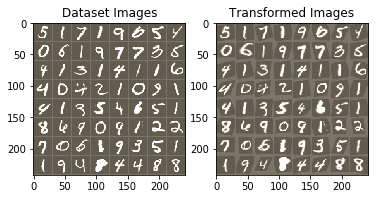

In [5]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    # Get a batch of training data
    data, _ = next(iter(test_loader))
    with torch.no_grad():
        data = Variable(data)

    data = data.cuda()
    
    # todo : clean up this mess
    input_tensor = data.cpu().data
    transformed_input_tensor = model.warp(data).cpu().data

    in_grid = convert_image_np(
        torchvision.utils.make_grid(input_tensor))

    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))

    # Plot the results side-by-side
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images')

    axarr[1].imshow(out_grid)
    axarr[1].set_title('Transformed Images')


for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()